In [1]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, solvers, vis

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# define geometry
geo = geometry.quarter_annulus()

# define discretization space (200 x 200 mesh, p=3)
kvs = 2 * (bspline.make_knots(3, 0.0, 1.0, 200),)

In [3]:
# set up the random diffusion coefficient
r_incl = 0.035      # radius of the random inclusions
num_incl = 100      # number of random inclusions

# compute centers for random inclusions
centers = []
while len(centers) < num_incl:
    cx, cy = 2 * rand(2)    # random numbers in [0,2]
    r = sqrt(cx**2 + cy**2)
    if 1 < r < 2:   # is it in the annulus?
        centers.append((cx, cy))

def diff_coeff(x, y):
    # 0.01 outside the inclusions, 1.0 inside them
    z = np.inf * ones_like(x*y)
    for (cx, cy) in centers:
        z = np.minimum(z, (x - cx)**2 + (y - cy)**2)
    return 0.01 + (sqrt(z) < r_incl)*0.99

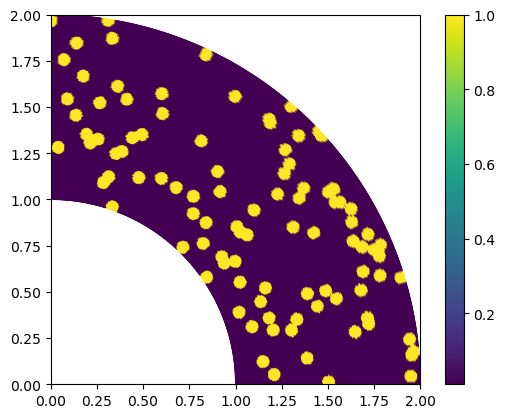

In [4]:
# plot the diffusion coefficient
vis.plot_field(diff_coeff, geo, res=300, physical=True);
axis('scaled');
colorbar();

In [7]:
# compute Dirichlet boundary values
g = lambda x,y: (4*(0.25 - (1.5-y)**2))**7  # Dirichlet BC function at inflow boundary

bcs = assemble.compute_dirichlet_bcs(kvs, geo,
        [('top', g), ('left', 0), ('right', 0)])

# set up and solve linear system
# - diffusion coefficient was generated above
# - convection field is clockwise rotation around the annulus (x[1], -x[0])
A = assemble.assemble(
    '(inner(diff_coeff * grad(u), grad(v)) + inner((x[1],-x[0]), grad(u)) * v) * dx',
    kvs, geo=geo, diff_coeff=diff_coeff)
LS = assemble.RestrictedLinearSystem(A, 0, bcs)   # rhs = 0

u = solvers.make_solver(LS.A).dot(LS.b)
u_func = geometry.BSplineFunc(kvs, LS.complete(u))

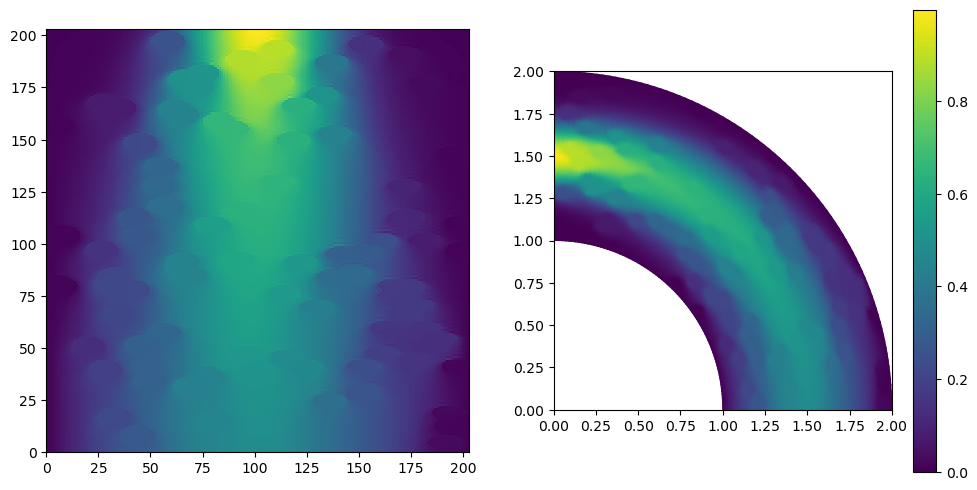

In [8]:
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
axis('scaled')

subplot(1,2,2)
vis.plot_field(u_func, geo)
axis('scaled')
colorbar();